In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from skimage import color
import tempfile
import os
from timeit import default_timer as timer
from tempfile import TemporaryFile
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
import decimal
from decimal import *
from sklearn.gaussian_process.kernels import ConstantKernel
import pickle

In [302]:
import collections

In [2]:
#Number of FP and HFR WN used for each different patient

FP_duo = 36
HFR_duo = 33

FP_17 = 32
HFR_17 = 33

FP_19 = 32
HFR_19 = 26


In [3]:
train_df_22_path ='/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_train.pkl'
train_df_109C_path ='/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P109C/P109_train.pkl'
val_df_22_path = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_val.pkl'
val_df_109_path = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P109C/P109_val.pkl'
test_df_22_path = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_test.pkl'
test_df_109_path = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P109C/P109_test.pkl'

train_17_path = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P17/P17_train.pkl'
val_17_path = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P17/P17_val.pkl'
test_17_path ='/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P17/P17_test.pkl'

train_19_path = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P19/P19_train.pkl'
val_19_path = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P19/P19_val.pkl'
test_19_path = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P19/P19_test.pkl'

In [4]:
#train_df_22 = pickle.load(open('/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_train.pkl','rb'))

In [5]:
#train_df_22.iloc[0:, 0:train_df_22.shape[1]-1].mean(axis=0)

In [6]:
def Axismaker(FP_WN, HFR_WN):
    
    #Interval limits for the Raman WN used for the measurements in the both WN-regions of interest
    #Fingerprint (FP) and high-frequency (HFR)
    FP_max = 1598.8
    FP_min = 1780.0
    FP_diff = FP_min - FP_max
    
    FP_WN = FP_WN
    FP_step = FP_diff/FP_WN
    
    HFR_max = 2796.6
    HFR_min = 3050.0
    
    HFR_diff = HFR_min - HFR_max
    
    HFR_WN = HFR_WN
    HFR_step = HFR_diff/HFR_WN
    
    FP_x_axis = np.linspace(FP_max, FP_min, num=FP_WN)
    HFR_x_axis = np.linspace(HFR_max, HFR_min, num=HFR_WN)
    Comb_x_axis = np.append(HFR_x_axis, FP_x_axis)
    
    return(Comb_x_axis)

In [7]:
#For modelling the two presumably different states (aSyn-Fluo (1) and None (0)) the dataframes have to be split, 
#by observing the aSYn-Fluo-state in the dataframe
def DF_divider(DF):
    
    DF_zero = DF[DF.aSyn_fluo == 0]
    DF_one = DF[DF.aSyn_fluo == 1]
    
    return(DF_zero, DF_one)
    
    
    

In [8]:
#Calculate mean, standard deviation and the quotient STD/mean for each WN in the sampled dataframe
def GP_calc(DF, FP, HFR):
        
    mean_buffer = DF.iloc[0:, 0:DF.shape[1]-1].mean(axis=0)
    print('Mean buffer ready')
    mean = mean_buffer.to_numpy(copy=True)
    print('Mean ready')
    
    STD_buffer = DF.iloc[0:, 0:DF.shape[1]-1].std(axis=0)
    print('SD_buffer ready')
    STD = STD_buffer.to_numpy(copy=True)
    print('SD ready')
    
    Quotient = np.divide(STD, mean)
    
    median_buffer = DF.iloc[0:, 0:DF.shape[1]-1].median(axis=0)
    print('Median buffer ready')
    median = median_buffer.to_numpy(copy=True)
    print('Median ready')
    
    Axis = Axismaker(FP, HFR)
    
    #Return all four yields (mean, SD, qoutient, median) in a list
    
    five_list = []
    five_list.append(Axis)
    five_list.append(mean)
    five_list.append(STD)
    five_list.append(Quotient)
    five_list.append(median)
    
    return(five_list)
    

In [9]:
#Feed in a path for a single Dataframe to load from a .pkl (appendmode = False) or two paths in a list to load and 
#append two dataframes of the same WN dimensionality
#the inpute is divided into two dataframes based on the label condition of aSYN and for the yielded DFs several 
#statistical values are calculated (Wave numbers, mean , standard deviation, SD/mean, median)
def GP_divide_and_calc(DF_or_2DF, FP, HFR, appendmode=False):
    
    if appendmode==False:
    
        DF = pickle.load(open(DF_or_2DF ,'rb'))

        Zero_DF, One_DF = DF_divider(DF)
        
        Zero_count = Zero_DF.shape[0]
        One_count = One_DF.shape[0]

        Zero_list = GP_calc(Zero_DF, FP, HFR)
        One_list = GP_calc(One_DF, FP, HFR)
        
        Zero_list.append(Zero_count)
        One_list.append(One_count)
        

        return(Zero_list, One_list)
    
    elif appendmode==True:
        
        DF1 = pickle.load(open(DF_or_2DF[0] ,'rb'))
        DF2 = pickle.load(open(DF_or_2DF[1] ,'rb'))
        
        DF = (DF1.append(DF2)).reset_index(drop=True)
        
        Zero_DF, One_DF = DF_divider(DF)
        
        Zero_count = Zero_DF.shape[0]
        One_count = One_DF.shape[0]

        Zero_list = GP_calc(Zero_DF, FP, HFR)
        One_list = GP_calc(One_DF, FP, HFR)
        
        Zero_list.append(Zero_count)
        One_list.append(One_count)

        return(Zero_list, One_list)
    

In [10]:
def Pickler(Input, Out_path_file_name):
    opening_file = open(Out_path_file_name+'.pkl', "wb")
    pickle.dump(Input, opening_file)
    opening_file.close()

In [11]:
#Creates a dataframe for all used WN-intervals and the corresponding data, using three lists, each containing 4
#arrays. The first are the WN values, the second the mean values, the third the SD values,
#the last the quotients between SD and mean.
# The order in which the lists have to be given in, corresponds to the order the axes haven been merged together.
#E.g. first P22_P109, then P17, then P19.

def Gauss_mapper(axis, list_1, list_2, list_3):
    
    df = pd.DataFrame(0, index=range(len(axis)), columns=('WN', 'Mean', 'SD', 'Quot', 'Median', 'Counts'))
    
    d1 = len(list_1[0])
    d2 = len(list_2[0])
    d3 = len(list_3[0])
    
    df['WN'][0:d1] = list_1[0]
    df['Mean'][0:d1] = list_1[1]
    df['SD'][0:d1] = list_1[2]
    df['Quot'][0:d1] = list_1[3]
    df['Median'][0:d1] = list_1[4]
    df['Counts'][0:d1] = list_1[5]
               
    df['WN'][(d1):(d1+d2)] = list_2[0]
    df['Mean'][(d1):(d1+d2)] = list_2[1]
    df['SD'][(d1):(d1+d2)] = list_2[2]
    df['Quot'][(d1):(d1+d2)] = list_2[3]
    df['Median'][(d1):(d1+d2)] = list_2[4]
    df['Counts'][(d1):(d1+d2)] = list_2[5]
               
    df['WN'][(d1+d2) : (d1+d2+d3)] = list_3[0]
    df['Mean'][(d1+d2) : (d1+d2+d3)] = list_3[1]
    df['SD'][(d1+d2) : (d1+d2+d3)] = list_3[2]
    df['Quot'][(d1+d2) : (d1+d2+d3)] = list_3[3]
    df['Median'][(d1+d2) : (d1+d2+d3)] = list_3[4]
    df['Counts'][(d1+d2) : (d1+d2+d3)] = list_3[5]
    
    df = df.sort_values(by=['WN'])
    
    return(df)
                     
    

In [12]:
def Dataframe_deduplicator(data):
    df = data
    #n=0
    for i in range(len(df['WN'])):

        testing = (df['WN'][i:i+1]).to_numpy(copy=True)
        
        #print(testing)

        t_cell = df[df['WN'] == testing[0]]
        
        #print(t_cell.shape[0])

        c_sum = t_cell['Counts'].sum(axis = 0)
        
        if t_cell.shape[0]>1:
        
        #n=n+1
        #print(n)

            for j in range(len(t_cell)):

                count = (t_cell['Counts'][j:j+1]).to_numpy(copy=True)

                cell_row = (t_cell.iloc[j:j+1, 0:]).to_numpy(copy=True)

                #print(cell_row)

                cell_row = cell_row * (count/c_sum)

                #print(len(cell_row[0]))

                #print('Cell row: ' + str(cell_row))

                for k in range(len(cell_row[0])):

                    #print('K is: ' + str(k))
                    #print('J is: ' + str(j))


                    #print('t_cell.iloc[j:j+1, k:k+1] is: ' + str(t_cell.iloc[j:j+1, k:k+1]))

                    t_cell.iloc[j:j+1, k:k+1] = cell_row[0][k]

            t_cell_mod_sum = t_cell.sum(axis=0)

            df[df['WN'] == testing[0]] = t_cell_mod_sum
        else:
            continue
    df = df.drop_duplicates(subset = ['WN'])
    return(df)
            
            
                   
        
        
        
        
        
        

In [13]:
def GP_Fitter(kernel, restarts, quot, WN_x_axis, means):
    
    #Definition of the Gaussian process
    #Contains alpha, that adds a set of values to the diagonal of the covariance matrix to simulate noise,
    #experimentally alpha is the quotient between a mean and its corresponding SD it is simply added to the diagonal variance
    #entries of the covariance matrix that normally are just 1 (1 + 1 * quotient)
    #is set to normalize_y=True so that the GP uses a fed in mean for calculations instead of a standard mean = 0
    #uses a set of predefined kernels and uses an optimizer to enhance the kernel parameters S_1 and length_scale

    gp_init = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=restarts, alpha=(quot), normalize_y=True)


    #Fitting the initialized GP to actual data corresponding to a fitting x_Axis defined by the wavenumbers tested for the
    #dataset of means

    gp_fit = gp_init.fit(np.reshape(WN_x_axis, (-1, 1)), means)
    
    return(gp_fit)

In [14]:
def GP_predict(WN_x_axis, gp_fit, means, plot=True):
    
    #Prediction of values from the GP and sampling from curves to create a model of our data
    #Printing a graphical presentation of the Gaussian process model with x-axis as wavenumbers and y-axis as Raman
    #intensity. The black curve is the mean of all samples from the Gaussian process and enveloped by a grey tubular
    #representation of one standard deviation. A scatterplot shows the mean values the GP was modeled after

    X = WN_x_axis #Interval of numbers to perform the process over
    X_resh = np.reshape(X, (X.shape[0], 1))
    y_mean, y_std = gp_fit.predict(X_resh, return_std=True) #Prediction using the GP with  training
    y_samples = gp_fit.sample_y(X_resh, 15) #Sample 15 curves ()
    
    if plot == True:
        #Plotting the data
        %matplotlib inline
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=False)
        fig.subplots_adjust(wspace=0.2)
        fig.suptitle('Raman intensities on each wavenumber')
        
        
        #ax1.figure(figsize=(6,6))
        #ax2.figure(figsize=(6,6)) 
        
        ax1.plot(X, y_mean, 'k', lw=3, zorder=9)
        ax1.scatter(WN_x_axis, means, c='r', s=50, zorder=10, edgecolors=(0, 0 ,0))
        ax1.fill_between(X, y_mean-y_std, y_mean+y_std, alpha=0.2, color='k')
        ax1.set_title('High-frequency-region')
        
        ax2.plot(X, y_mean, 'k', lw=3, zorder=9)
        ax2.scatter(WN_x_axis, means, c='r', s=50, zorder=10, edgecolors=(0, 0 ,0))
        ax2.fill_between(X, y_mean-y_std, y_mean+y_std, alpha=0.2, color='k')
        ax2.set_title('Fingerprint-region')
        
        ax1.set(xlabel='Wavenumber (WN)', ylabel='Intensity')
        ax2.set(xlabel='Wavenumber (WN)', ylabel='Intensity')
              
        ax1.set_xlim(3050, 2796.6)
        ax1.set_ylim(0, 0.4)
        ax2.set_xlim(1780, 1598.8)
        ax2.set_ylim(0, 0.4)               
        
        return(y_mean)
    else:
        return(y_mean)

In [15]:
Duo_path_list = []
Duo_path_list.append(train_df_22_path)
Duo_path_list.append(train_df_109C_path)
Zero_P22_P109, One_P22_P109 = GP_divide_and_calc(Duo_path_list, FP_duo, HFR_duo, appendmode=True)

Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready
Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready


In [16]:
Zero_P22_P109_train = Zero_P22_P109
One_P22_P109_train = One_P22_P109

In [17]:
Zero_P22_train, One_P22_train = GP_divide_and_calc(train_df_22_path, FP_duo, HFR_duo, appendmode=False)

Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready
Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready


In [18]:
Zero_P109_train, One_P109_train = GP_divide_and_calc(train_df_109C_path, FP_duo, HFR_duo, appendmode=False)

Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready
Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready


In [19]:
Zero_17_train, One_17_train = GP_divide_and_calc(train_17_path, FP_17, HFR_17, appendmode=False)

Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready
Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready


In [20]:
Zero_19_train, One_19_train = GP_divide_and_calc(train_19_path, FP_19, HFR_19, appendmode=False)

Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready
Mean buffer ready
Mean ready
SD_buffer ready
SD ready
Median buffer ready
Median ready


In [21]:
save_list = list((Zero_P22_P109_train, One_P22_P109_train, Zero_17_train, One_17_train, Zero_19_train, One_19_train))
Pickler(save_list, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Lists_for_GP/first_save_list')

In [22]:
P22_P109C_axis = Axismaker(36, 33)
P17_axis = Axismaker(32, 33)
P19_axis = Axismaker(32, 26)

In [23]:
#test_df = pd.DataFrame(np.array([[1,2,6], [4,5,6], [7,8,9]]), columns=('A', 'B','C'))

In [24]:
All_WN_comb = np.append(P22_P109C_axis, np.append(P17_axis, P19_axis))

In [25]:
Zero_df = Gauss_mapper(All_WN_comb, Zero_P22_P109_train, Zero_17_train, Zero_19_train)

<ipython-input-11-17a16deb0ca6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean'][0:d1] = list_1[1]
<ipython-input-11-17a16deb0ca6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SD'][0:d1] = list_1[2]
<ipython-input-11-17a16deb0ca6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quot'][0:d1] = list_1[3]
<ipython-input-11-17a16deb0ca6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [26]:
One_df = Gauss_mapper(All_WN_comb, One_P22_P109_train, One_17_train, One_19_train)

<ipython-input-11-17a16deb0ca6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean'][0:d1] = list_1[1]
<ipython-input-11-17a16deb0ca6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SD'][0:d1] = list_1[2]
<ipython-input-11-17a16deb0ca6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quot'][0:d1] = list_1[3]
<ipython-input-11-17a16deb0ca6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [27]:
test_cell = Zero_df[Zero_df['WN'] == 1598.8]

In [29]:
test_cell.iloc[0:1, 0:6]

,WN,Mean,SD,Quot,Median,Counts
102,1598.8,0.016827,0.020515,1.219129,0.010833,24568852


In [30]:
test_cell['Counts'].sum(axis = 0)

70681101

In [31]:
test_cell.iloc[0:1, 0:]

,WN,Mean,SD,Quot,Median,Counts
102,1598.8,0.016827,0.020515,1.219129,0.010833,24568852


In [32]:
test_cell['Counts'][0:1].to_numpy(copy=True)

array([24568852])

In [33]:
Zero_df_mod = Dataframe_deduplicator(Zero_df)

/bph/puredata1/bioinfdata/user/phikie/anaconda3/envs/All_in_one_GPU/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/bph/puredata1/bioinfdata/user/phikie/anaconda3/envs/All_in_one_GPU/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/bph/puredata1/bioinfdata/user/phikie/anaconda3/envs/All_in_one_GPU/lib/python3.9/site-packages/pandas/core/indexing.py:723: Setting

In [34]:
One_df_mod = Dataframe_deduplicator(One_df)

In [35]:
Zero_df_mod['Counts'].unique()

array([28855791.87606199, 36708247.        , 20371080.45776513,
       31840996.36327289,  9404002.        ])

In [428]:
One_df_mod.shape

(123, 6)

In [37]:
One_df_mod

,WN,Mean,SD,Quot,Median,Counts
102,1598.800000,0.058889,0.092063,1.369030,0.021857,1.111515e+06
34,1603.977143,0.135763,0.227363,1.674706,0.035595,9.975370e+05
161,1604.645161,0.021762,0.026917,1.221699,0.015561,1.166154e+06
35,1609.154286,0.138425,0.231900,1.675270,0.032500,9.975370e+05
104,1610.490323,0.023271,0.027280,1.165682,0.017754,1.166154e+06
...,...,...,...,...,...,...
157,3029.728000,0.007544,0.004782,0.633888,0.007500,6.787850e+05
99,3034.162500,0.042643,0.094450,1.569489,0.010320,1.233921e+06
158,3039.864000,0.006683,0.004514,0.675471,0.006667,6.787850e+05
31,3042.081250,0.044366,0.096518,1.543057,0.010320,1.233921e+06


In [222]:
#Definition of kernels for the Gaussian process
#Define the Gauss process for regression and its Kernel (important parameter to adjust is length_scale and the scaling factor
# S_1 (default=1))
S_1 = 1
#Radial-basis-function kernel
kernel_dem = S_1*RBF(length_scale=(1), length_scale_bounds=(0.1, 10))
kernel_1 = S_1* RBF(length_scale=(0.1), length_scale_bounds=(0.000001, 10000))
kernel_2 = S_1* RBF(length_scale=(100), length_scale_bounds=(100, 1000))
kernel_3 = S_1* ExpSineSquared(length_scale=100, periodicity=1.0, length_scale_bounds=(0.01, 100), periodicity_bounds=(1.0, 100))

#Set kernel to the active kernel used for the iteration of the following Gaussian process
kernel = kernel_1

#No. of restarts for the Gaussian process

restarts = 100

In [223]:
GP_test_run_zero = GP_Fitter(kernel, restarts, Zero_df_mod['Quot'].to_numpy(copy=True), Zero_df_mod['WN'].to_numpy(copy=True), Zero_df_mod['Mean'].to_numpy(copy=True))

In [224]:
GP_test_run_one = GP_Fitter(kernel, restarts, One_df_mod['Quot'].to_numpy(copy=True), One_df_mod['WN'].to_numpy(copy=True), One_df_mod['Mean'].to_numpy(copy=True))

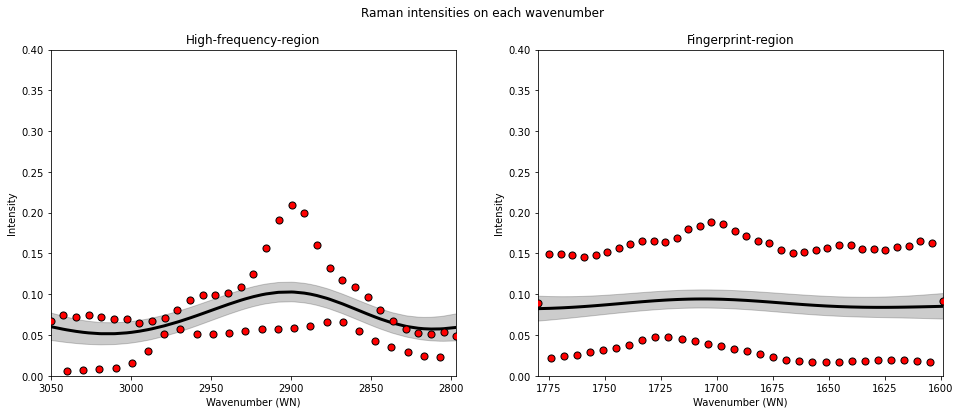

In [450]:
Big_mod_zero = GP_predict(Zero_df_mod['WN'].to_numpy(copy=True), GP_test_run_zero, Zero_df_mod['Mean'].to_numpy(copy=True), plot=True)

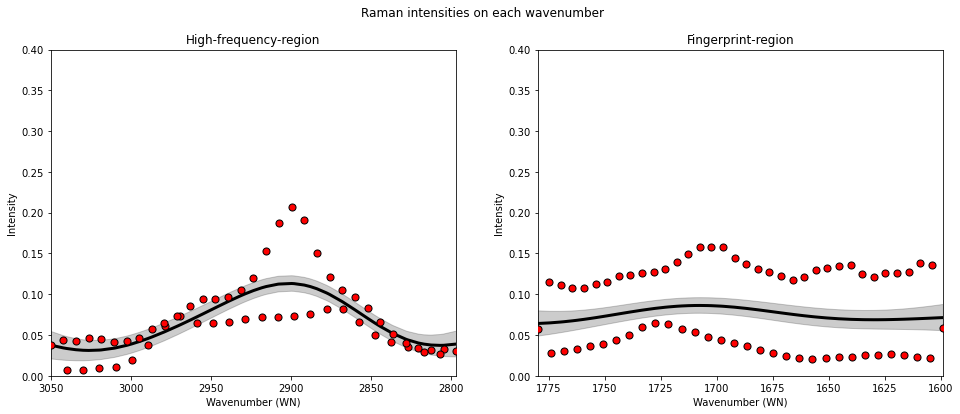

In [451]:
Big_mod_one = GP_predict(One_df_mod['WN'].to_numpy(copy=True), GP_test_run_one, One_df_mod['Mean'].to_numpy(copy=True), plot=True)

In [227]:
Zero_19_train_array = np.array(Zero_19_train[0:5])

In [228]:
Zero_19_train_array = Zero_19_train_array.T

In [229]:
z_19_tr_df = pd.DataFrame(Zero_19_train_array, index = range(Zero_19_train_array.shape[0]), columns=('WN', 'Mean', 'SD', 'Quot', 'Median'))

In [230]:
z_19_tr_df = z_19_tr_df.sort_values(by=['WN'])

In [231]:
def Single_DF_prepper(stat_val_list):
    DF_array = np.array(stat_val_list[0:5])
    DF_array = DF_array.T
    DF_array = pd.DataFrame(DF_array, index = range(DF_array.shape[0]), columns=('WN', 'Mean', 'SD', 'Quot', 'Median'))
    
    DF_array = DF_array.sort_values(by=['WN'])
    
    return(DF_array)

In [232]:
z_19_tr_df = Single_DF_prepper(Zero_19_train)

In [233]:
#z_19_tr_df

In [234]:
GP_test_run_zero_P19 = GP_Fitter(kernel, restarts, z_19_tr_df['Quot'].to_numpy(copy=True), z_19_tr_df['WN'].to_numpy(copy=True), z_19_tr_df['Mean'].to_numpy(copy=True))

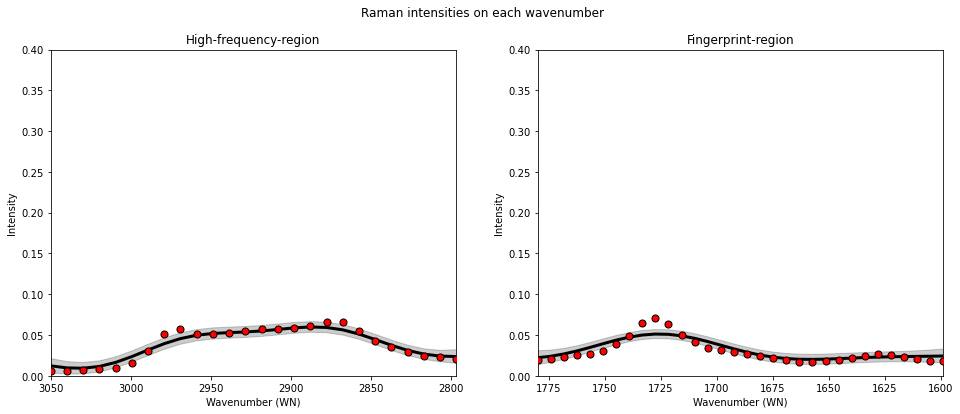

In [235]:
Zero_pred_P19 = GP_predict(z_19_tr_df['WN'].to_numpy(copy=True), GP_test_run_zero_P19, z_19_tr_df['Mean'].to_numpy(copy=True), plot=True)

In [236]:
o_19_tr_df = Single_DF_prepper(One_19_train)

In [237]:
GP_test_run_one_P19 = GP_Fitter(kernel, restarts, o_19_tr_df['Quot'].to_numpy(copy=True), o_19_tr_df['WN'].to_numpy(copy=True), o_19_tr_df['Mean'].to_numpy(copy=True))

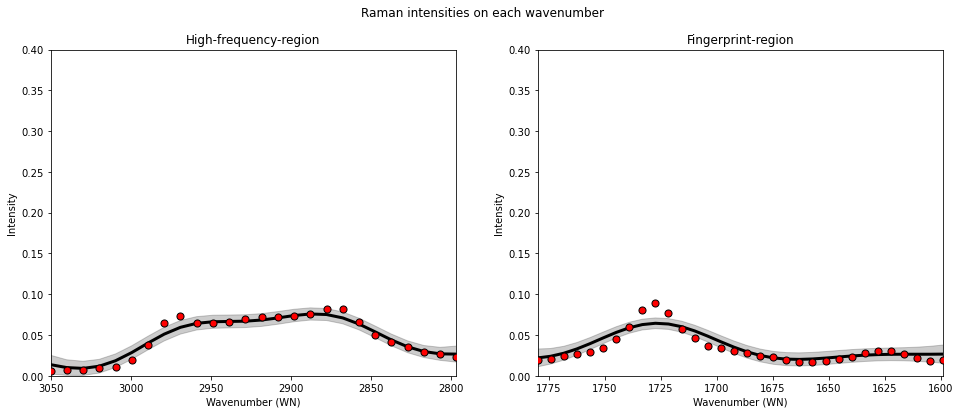

In [238]:
One_pred_P19 = GP_predict(o_19_tr_df['WN'].to_numpy(copy=True), GP_test_run_one_P19, o_19_tr_df['Mean'].to_numpy(copy=True), plot=True)

In [307]:
def GP_pred_and_print(DF, kernel, restarts):
    DF = Single_DF_prepper(DF)
    GP_fit = GP_Fitter(kernel, restarts, DF['Quot'].to_numpy(copy=True), DF['WN'].to_numpy(copy=True), DF['Mean'].to_numpy(copy=True))
    GP_prediction = GP_predict(DF['WN'].to_numpy(copy=True), GP_fit, DF['Mean'].to_numpy(copy=True), plot=True)
    
    return(GP_fit)

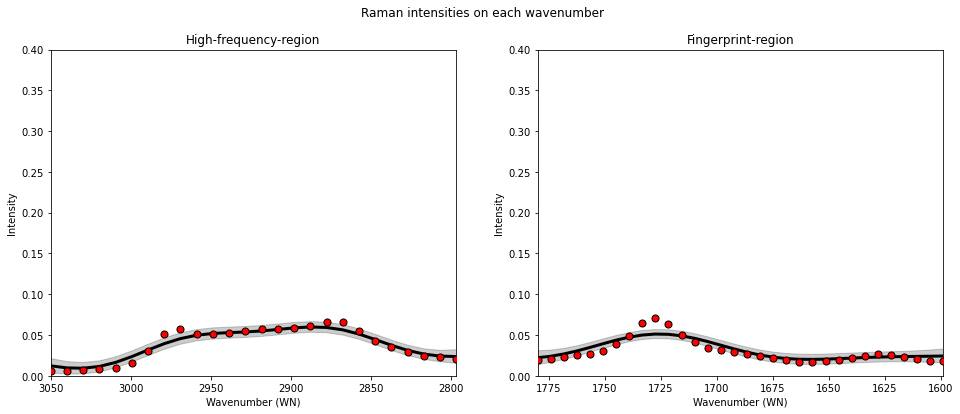

In [405]:
Model_19_train_zero = GP_pred_and_print(Zero_19_train, kernel, restarts)

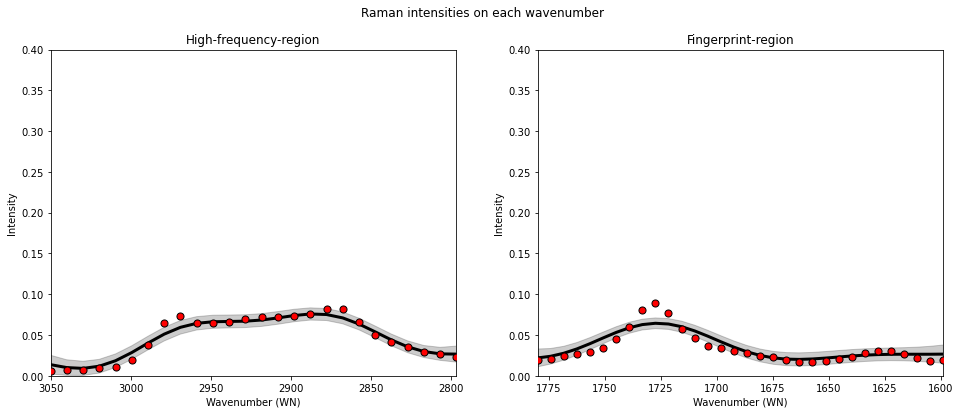

In [406]:
Model_19_train_one = GP_pred_and_print(One_19_train, kernel, restarts)

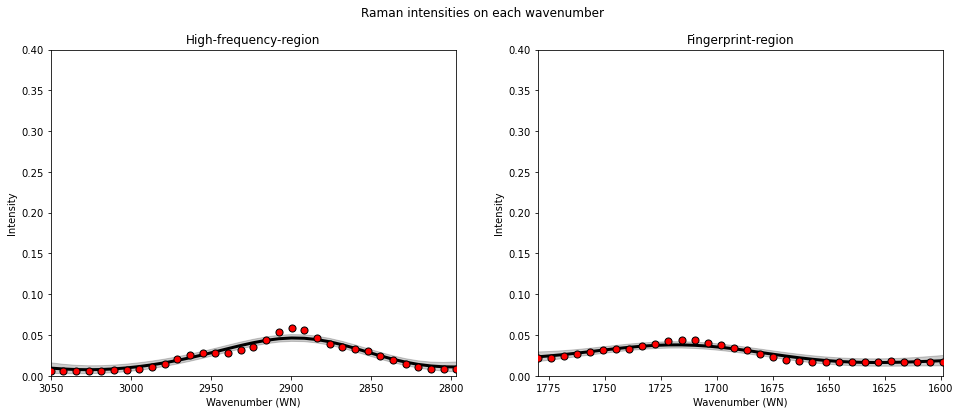

In [407]:
Model_17_train_zero = GP_pred_and_print(Zero_17_train, kernel, restarts)

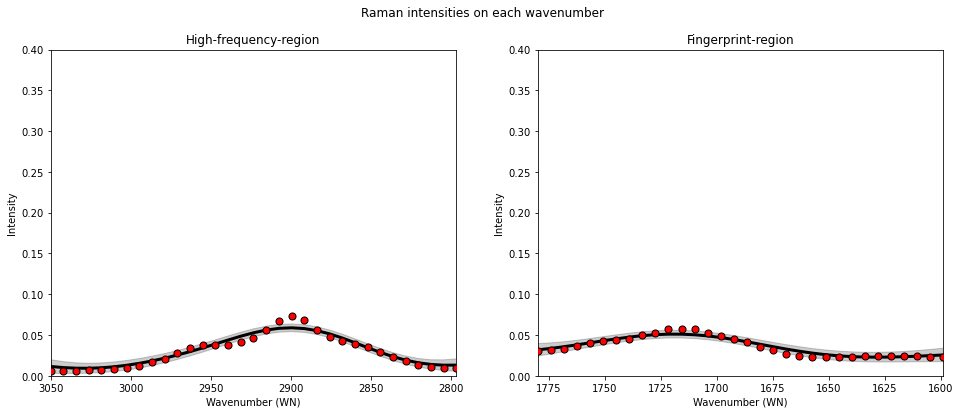

In [408]:
Model_17_train_one = GP_pred_and_print(One_17_train, kernel, restarts)

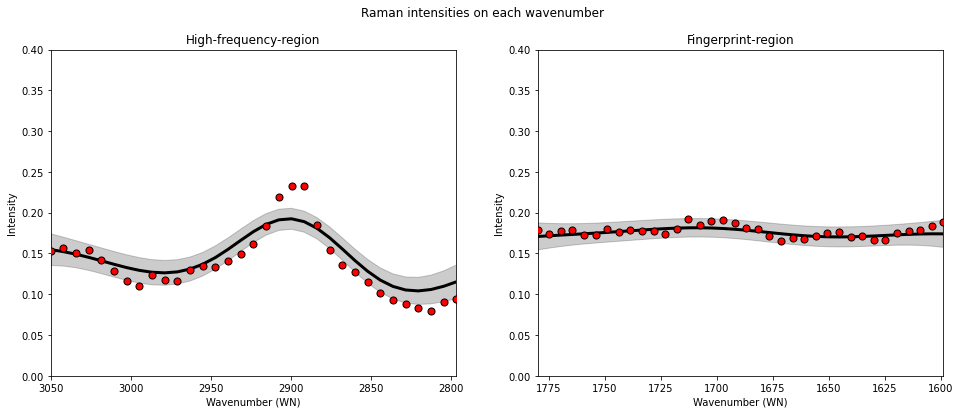

In [409]:
Model_22_train_zero = GP_pred_and_print(Zero_P22_train, kernel, restarts)

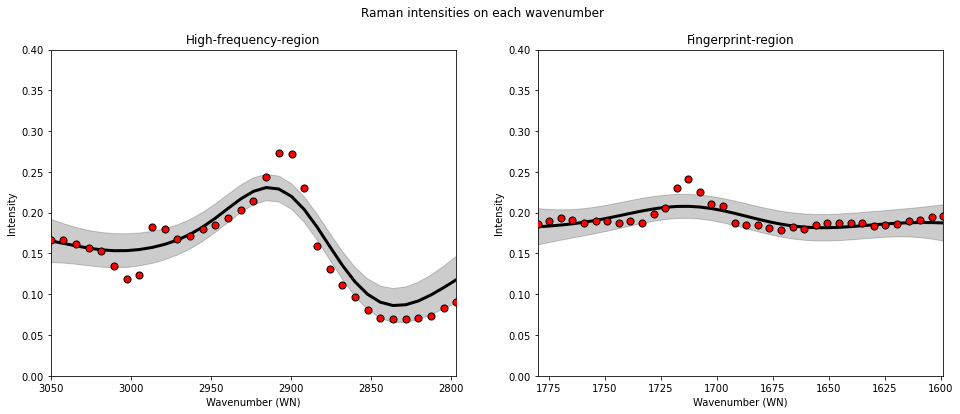

In [410]:
Model_22_train_one = GP_pred_and_print(One_P22_train, kernel, restarts)

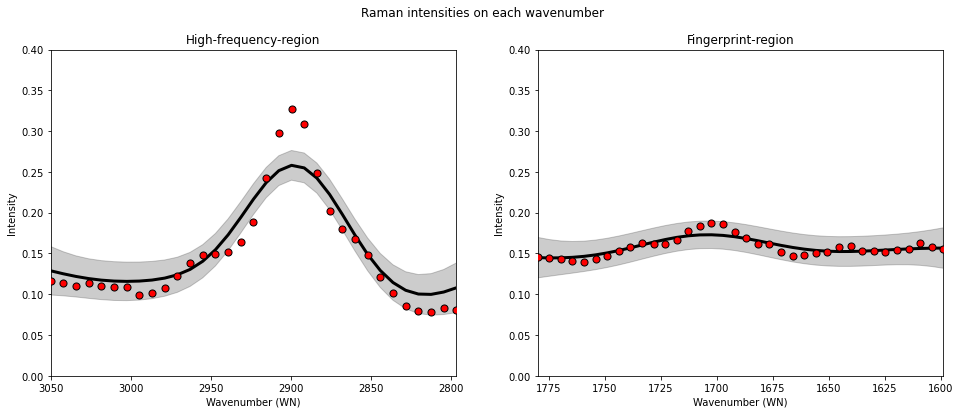

In [413]:
Model_109_train_zero = GP_pred_and_print(Zero_P109_train, kernel, restarts)

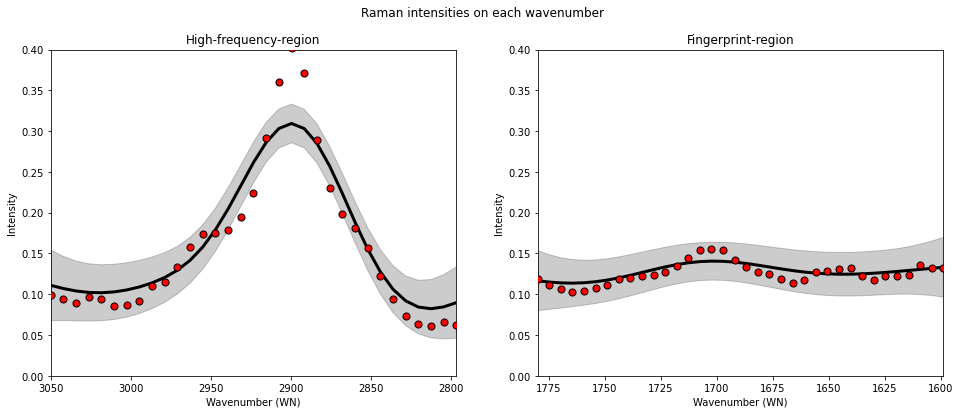

In [414]:
Model_109_train_one = GP_pred_and_print(One_P109_train, kernel, restarts)

In [251]:
def Dataframe_processor(DF_path_1, DF_path_2, appendmode=False):
    
    if appendmode == True:
    
        DF_1 = pickle.load(open(DF_path_1, 'rb'))
        DF_2 = pickle.load(open(DF_path_2, 'rb'))


        DF_C = DF_1.append(DF_2)
        DF_C = DF_C.reset_index(drop=True)


        DF_C_signals = DF_C.iloc[:, 0:(DF_C.shape[1]-1)]
        DF_C_signals = DF_C_signals.to_numpy(copy=True)


        DF_C_classes = DF_C.iloc[:, (DF_C.shape[1]-1):DF_C.shape[1]]
        DF_C_classes = DF_C_classes.to_numpy(copy=True)
    
        return(DF_C_signals, DF_C_classes)
    
    if appendmode == False:
        
        DF_C = pickle.load(open(DF_path_1, 'rb'))
        
        DF_C_signals = DF_C.iloc[:, 0:(DF_C.shape[1]-1)]
        DF_C_signals = DF_C_signals.to_numpy(copy=True)


        DF_C_classes = DF_C.iloc[:, (DF_C.shape[1]-1):DF_C.shape[1]]
        DF_C_classes = DF_C_classes.to_numpy(copy=True)
    
        return(DF_C_signals, DF_C_classes)

In [416]:
def Confus_analyzer_Gauss(Conf):
    
    TN, FN, TP , FP = Conf[0], Conf[1], Conf[2], Conf[3]
    
    Accuracy = ((TP+TN)/(TP+TN+FP+FN))
    print('Accuracy: ' + str(Accuracy))
    #Sensitivity or Recall; rate of TP on all positives
    Recall = ((TP)/(TP+FN))
    print('Recall: ' + str(Recall))
    
    #Percentage of correct TP predictions
    Precision = ((TP)/(TP+FP))
    print('Precision: ' + str(Precision))
    #F1 score
    F1_score = 2*((Precision*Recall)/(Precision+Recall))
    print('F1_Score: ' + str(F1_score))
    Misclass = ((FP+FN)/(TP+TN+FP+FN))
    print('Misclassifications: ' + str(Misclass))
    
    Confu_array = np.array([Accuracy, Recall, Precision, F1_score, Misclass])
    
    
    return(Confu_array)

In [439]:
def GP_classification(data_path, Zero_M, One_M, axis):
    
    DF, classes = Dataframe_processor(data_path, None, appendmode=False) #creates a DF with all cont. signal info
    # for every pixel of one patient
    classes = np.reshape(classes, (-1))
    DF = np.nan_to_num(DF)
    
    
    
    X_resh = np.reshape(axis, (axis.shape[0], 1))
    
    zero_y_mean, zero_y_std = Zero_M.predict(X_resh, return_std=True) #Prediction using the GP with  training
    
    one_y_mean, one_y_std = One_M.predict(X_resh, return_std=True) #Prediction using the GP with  training
    
    zero_diff = DF - zero_y_mean
    zero_diff = np.sum(np.abs(zero_diff), axis=1)
    one_diff = DF - one_y_mean
    one_diff = np.sum(np.abs(one_diff), axis=1)
    
   
    
    #Empty DF for memory problems
    DF = 0
    
    diff_diff = zero_diff - one_diff
    diff_diff[diff_diff > 0] = 5 #Encodes for a prediction of a positive label
    diff_diff[diff_diff <= 0] = 2 # Encodes for a prediction of a negative label
    
    diff_class_pred = diff_diff - classes
    
    print(np.histogram(classes))
    print(np.histogram(diff_class_pred))
    
    confus_counts = np.bincount(diff_class_pred.astype('int64'))
    
    #order of outputs is ; TN, FN, TP , FP
    confus_output = np.array([confus_counts[2], confus_counts[1], confus_counts[4], confus_counts[5]])
    
    output = Confus_analyzer_Gauss(confus_output)
    
    return(output)
    
    
    

In [440]:
test_classif = GP_classification(train_df_22_path, Model_22_train_zero, Model_22_train_one, P22_P109C_axis)

(array([6550372,       0,       0,       0,       0,       0,       0,
             0,       0,   55646]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([  34218,       0, 5564692,       0,       0,       0,       0,
         21428,       0,  985680]), array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]))
Accuracy: 0.8456107749025207
Recall: 0.38507709449017
Precision: 0.021276764756113543
F1_Score: 0.0403254186763823
Misclassifications: 0.1543892250974793


In [441]:
test_classif

array([0.84561077, 0.38507709, 0.02127676, 0.04032542, 0.15438923])

In [421]:
P17_classif_train = GP_classification(train_17_path, Model_17_train_zero, Model_17_train_one, P17_axis)
P17_classif_val = GP_classification(val_17_path, Model_17_train_zero, Model_17_train_one, P17_axis)
P17_classif_test = GP_classification(test_17_path, Model_17_train_zero, Model_17_train_one, P17_axis)

Accuracy: 0.5891212455023307
Recall: 0.5271881657429326
Precision: 0.06877821503052949
F1_Score: 0.1216815652519184
Misclassifications: 0.41087875449766936
Accuracy: 0.5893056812431312
Recall: 0.5263058161771856
Precision: 0.06878960715954707
F1_Score: 0.12167584868192566
Misclassifications: 0.41069431875686885
Accuracy: 0.5886461568566251
Recall: 0.5267398020238232
Precision: 0.06845208659757322
F1_Score: 0.12115903872963883
Misclassifications: 0.41135384314337486


In [424]:
P17_results = np.array([P17_classif_train, P17_classif_val, P17_classif_test])
np.save('/bph/puredata1/bioinfdata/user/phikie/GP_RESULTATE/P17_naive.npy', P17_results)

In [425]:
P19_classif_train = GP_classification(train_19_path, Model_19_train_zero, Model_19_train_one, P19_axis)
P19_classif_val = GP_classification(val_19_path, Model_19_train_zero, Model_19_train_one, P19_axis)
P19_classif_test = GP_classification(test_19_path, Model_19_train_zero, Model_19_train_one, P19_axis)

Accuracy: 0.5260758756482706
Recall: 0.6344512621816923
Precision: 0.0868082522828549
F1_Score: 0.1527206341798663
Misclassifications: 0.4739241243517293
Accuracy: 0.5260516103053992
Recall: 0.6336026014917284
Precision: 0.08661961842516584
F1_Score: 0.15240411655374575
Misclassifications: 0.47394838969460085
Accuracy: 0.5264459809121008
Recall: 0.6355694453039585
Precision: 0.0869873939496605
F1_Score: 0.15303025787737912
Misclassifications: 0.4735540190878992


In [426]:
P19_results = np.array([P19_classif_train, P19_classif_val, P19_classif_test])
np.save('/bph/puredata1/bioinfdata/user/phikie/GP_RESULTATE/P19_naive.npy', P19_results)

In [443]:
P109_classif_train = GP_classification(train_df_109C_path, Model_109_train_zero, Model_109_train_one, P22_P109C_axis)
P109_classif_val = GP_classification(val_df_109_path, Model_109_train_zero, Model_109_train_one, P22_P109C_axis)
P109_classif_test = GP_classification(test_df_109_path, Model_109_train_zero, Model_109_train_one, P22_P109C_axis)

(array([30157875,        0,        0,        0,        0,        0,
              0,        0,        0,   941891]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([  127524,        0,  7611791,        0,        0,        0,
              0,   814367,        0, 22546084]), array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]))
Accuracy: 0.2709395948509709
Recall: 0.8646085375059323
Precision: 0.03486092798465235
F1_Score: 0.0670196312766893
Misclassifications: 0.7290604051490291
(array([8616475,       0,       0,       0,       0,       0,       0,
             0,       0,  269196]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([  36306,       0, 2172232,       0,       0,       0,       0,
        232890,       0, 6444243]), array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]))
Accuracy: 0.27067421244833395
Recall: 0.8651317255828467
Precision: 0.03487874211881058
F1_Score: 0.06705412312028411
Misclassifications: 0.7

In [445]:
P109_results = np.array([P109_classif_val, P109_classif_test])
np.save('/bph/puredata1/bioinfdata/user/phikie/GP_RESULTATE/P109_naive.npy', P109_results)

In [435]:
P22_classif_train = GP_classification(train_df_22_path, Model_22_train_zero, Model_22_train_one, P22_P109C_axis)
P22_classif_val = GP_classification(val_df_22_path, Model_22_train_zero, Model_22_train_one, P22_P109C_axis)
P22_classif_test = GP_classification(test_df_22_path, Model_22_train_zero, Model_22_train_one, P22_P109C_axis)

Accuracy: 0.8456107749025207
Recall: 0.38507709449017
Precision: 0.021276764756113543
F1_Score: 0.0403254186763823
Misclassifications: 0.1543892250974793
Accuracy: 0.8455695437991203
Recall: 0.3863076047790632
Precision: 0.02122729988467577
F1_Score: 0.04024326397829458
Misclassifications: 0.1544304562008797
Accuracy: 0.8450463490825552
Recall: 0.3819238377843719
Precision: 0.021403676526631606
F1_Score: 0.040535663904362605
Misclassifications: 0.1549536509174448


In [446]:
P22_results = np.array([P22_classif_train, P22_classif_val, P22_classif_test])
np.save('/bph/puredata1/bioinfdata/user/phikie/GP_RESULTATE/P22_naive.npy', P22_results)

In [453]:
P_17_big = GP_classification(test_17_path, GP_test_run_zero, GP_test_run_one, P17_axis)
P_19_big = GP_classification(test_19_path, GP_test_run_zero, GP_test_run_one, P19_axis)
P_109_big = GP_classification(test_df_109_path, GP_test_run_zero, GP_test_run_one, P22_P109C_axis)
P22_big = GP_classification(test_df_22_path, GP_test_run_zero, GP_test_run_one, P22_P109C_axis)

(array([3510406,       0,       0,       0,       0,       0,       0,
             0,       0,  199721]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([   6773,       0,   20039,       0,       0,       0,       0,
        192948,       0, 3490367]), array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]))
Accuracy: 0.05740692973582845
Recall: 0.9660876923308015
Precision: 0.05238433313468981
F1_Score: 0.0993799696938169
Misclassifications: 0.9425930702641715
(array([1343435,       0,       0,       0,       0,       0,       0,
             0,       0,   96954]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([    911,       0,   17778,       0,       0,       0,       0,
         96043,       0, 1325657]), array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]))
Accuracy: 0.07902101446206546
Recall: 0.9906037914887472
Precision: 0.06755503974115495
F1_Score: 0.1264843736624669
Misclassifications: 0.9209789855379346
(arr

In [455]:
Big_mod_results = np.array([P_17_big, P_19_big, P_109_big, P22_big])
np.save('/bph/puredata1/bioinfdata/user/phikie/GP_RESULTATE/Big_model_naive.npy', Big_mod_results)